In [1]:
import torch,sys
sys.path.append('../')
import numpy as np
import torch.nn as nn
from torch.optim import Adam,SGD,lr_scheduler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import DiceLoss, SquarePad,SquarePad255
from torch.utils.data import Dataset, DataLoader,ConcatDataset,Subset
from UNET_LIB.InceptionUnet import InceptionUNet
from LAIPAS_Images.LAIPAS_DATA import LAIPAS_Dataset
from torch.utils.tensorboard import SummaryWriter
num_classes=4

# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=False)
model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

# teacher_net = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)
teacher_net = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=False)
teacher_net.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
teacher_net.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
    
with torch.no_grad():
    for ema_para,para in zip(teacher_net.parameters(),model.parameters()):
        ema_para.data = para.data

model = nn.DataParallel(model).cuda()
teacher_net = nn.DataParallel(teacher_net).cuda()

img_preprocess = transforms.Compose([    
#     SquarePad(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(0,1),
])

val_preprocess = transforms.Compose([    
#     SquarePad(),
    transforms.ToTensor(),
    transforms.Normalize(0,1),
])


msk_preprocess = transforms.Compose([])

epochs = 120
variant = '_pat_bal'
optim_spec = 'SGDL'
weighted = ''
ignore=False
loss_spec = 'CE_fixed'
assert loss_spec in ['Dice', 'CE','CE_fixed', 'CE_dynamic'] 
assert weighted in ['_weighted','']
# model_name = f'DLab50_LAIPAS_{variant}_o{optim_spec}{weighted}_no255_MT_wCTL'
model_name = f'DLab101_LAIPAS_{variant}_o{optim_spec}{weighted}_no255_MT_wCTL'
train_size = 384

#PAS data, labeled, sample 4 from this set
train_DATA = LAIPAS_Dataset('/data/LAIPAS_Images/', 'train'+variant, 
                                img_preprocess, msk_preprocess,crop_size=train_size,ignore=ignore)
#No_PAS data, labeled, sample 4 from this set
ctl_DATA0 = LAIPAS_Dataset('/data/LAIPAS_Images/', 'ctl', 
                                img_preprocess, msk_preprocess,crop_size=train_size,ignore=ignore)
#sample 8 from this set
unlabeled_DATA_train =  LAIPAS_Dataset('/data/LAIPAS_Images/', 'unlabeled' + variant, 
                                img_preprocess, msk_preprocess,crop_size=train_size, ignore=ignore) 



val_tune = Subset(LAIPAS_Dataset('/data/LAIPAS_Images/', 'val', img_preprocess, msk_preprocess,
                                  crop_size=train_size,ignore=ignore),range(0,28))

val_test = Subset(LAIPAS_Dataset('/data/LAIPAS_Images/', 'val', val_preprocess, msk_preprocess,
                          rot = False, resize=False,crop_size = 1024,ignore=False), range(28,72))


Using cache found in /home/yz696/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /home/yz696/.cache/torch/hub/pytorch_vision_v0.10.0


In [2]:
#sample 4
loader_l_pa = DataLoader(train_DATA, batch_size=4, shuffle=True, drop_last=True, num_workers=4)
#sample 4
loader_l_npa= DataLoader(ctl_DATA0, batch_size=4, shuffle=True, drop_last=True, num_workers=4)
iter_l_npa = iter(loader_l_npa)
# #sample 8
loader_u_tr = DataLoader(unlabeled_DATA_train, batch_size=8, shuffle=True, drop_last=True, num_workers=8)
iter_u_tr = iter(loader_u_tr)


tune_loader = DataLoader(val_tune, batch_size=8, shuffle=False, drop_last=False, num_workers=8)
test_loader = DataLoader(val_test, batch_size=8, shuffle=False, drop_last=False, num_workers=8)

In [3]:
min_loss = np.inf
fin_epoch = 0
if optim_spec == 'AD':
    optimizer = Adam(model.parameters(),lr=1e-4,eps=0.1, weight_decay=1e-6)

elif optim_spec == 'SGDL':
    poly = lambda iter_count: (1-iter_count/(len(loader_l_pa)*epochs))**0.9
    optimizer = SGD([{'params':model.module.backbone.parameters(), 'lr': 1e-2},
                     {'params': model.module.classifier.parameters(), 'lr': 1e-1},
                    ],momentum=0.9,weight_decay=5e-4)
    scheduler = lr_scheduler.LambdaLR(optimizer, poly)
elif optim_spec == 'SGD':
    poly = lambda iter_count: (1-iter_count/(len(loader_l_pa)*epochs))**0.9
    optimizer = SGD(model.parameters(),lr=1e-2,momentum=0.9,weight_decay=1e-3)
    scheduler = lr_scheduler.LambdaLR(optimizer, poly)

else:
    assert False

try:
        checkpoint = torch.load(f'/data/LAIPAS_Images/model_checkpoints/{model_name}.pth')
        fin_epoch = checkpoint['fin_epoch']
        min_loss = checkpoint['min_loss']
        model.load_state_dict(checkpoint['model_state_dict'])
        teacher_net.load_state_dict(checkpoint['teacher_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print('optimizer loaded')
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print('scheduler loaded')
        del checkpoint
except:
    if fin_epoch ==0:
        print(f'new model training {model_name}')
    else:
        del checkpoint


new model training DLab101_LAIPAS__pat_bal_oSGDL_no255_MT_wCTL


In [4]:
#methods follows MT and https://openreview.net/pdf?id=2o-qQu-mZa-
if loss_spec == 'Dice':
    ce_fn = DiceLoss() 
elif loss_spec == 'CE_fixed':
    ce_fn = nn.CrossEntropyLoss(torch.tensor([0.5,1,1,0.3],device='cuda'), ignore_index=255)
elif weighted == '':
    ce_fn = nn.CrossEntropyLoss(ignore_index=255)
else:
    ce_fn = nn.CrossEntropyLoss(ignore_index=255, reduction='none')
    
torch.cuda.empty_cache()
mse_fn = nn.MSELoss()
softmax = nn.Softmax(dim=1)
min_loss = np.inf
writer = SummaryWriter()
iter_count=-1.
alpha = 0.95

pbar = tqdm(range(epochs-fin_epoch))
total_iter = epochs*len(loader_l_pa)
for e in pbar:
    train_loss, val_loss, val_loss_raw = 0,0,0
    
    model.train()
    for idx,(X0,y0,w) in enumerate(loader_l_pa):
        try:
            X_npa, y_npa = next(iter_l_npa)  
        except StopIteration:
            iter_l_npa = iter(loader_l_npa)
            X_npa, y_npa = next(iter_l_npa)
            
        X = torch.cat([X0.cuda(), X_npa.cuda()]).contiguous()
        y = torch.cat([y0.cuda(), y_npa.cuda()]).contiguous()
        
        try:
            X_unlabeled, _ = next(iter_u_tr)
        except StopIteration:
            iter_u_tr = iter(loader_u_tr)
            X_unlabeled, _ = next(iter_u_tr)
        X_unlabeled=X_unlabeled.cuda().contiguous()
        
        iter_count += 1
        
       
        optimizer.zero_grad()
        
        if 'DLab' in model_name:
            yhat =  model(X)['out']
            yhat_u= softmax(model(X_unlabeled)['out'])
            
        else:
            yhat =  model(X)
            yhat_u= softmax(model(X_unlabeled))
            
        with torch.no_grad():
            #update the mean teacher model
            alpha_ = min(1-1/(e+1), alpha)
            for ema_para, para in zip(teacher_net.parameters(), model.parameters()):
                ema_para.data = ema_para.data*alpha + para.data*(1-alpha_)
            
            if 'DLab' in model_name:
                y_unlabeled = softmax(teacher_net(X_unlabeled)['out'])
            else:
                y_unlabeled = softmax(teacher_net(X_unlabeled))
            
        if weighted != '':
            loss = ((ce_fn(yhat,y)*w.cuda()).mean() + mse_fn(yhat_u,y_unlabeled))
        else:
            loss = (ce_fn(yhat,y) + mse_fn(yhat_u,y_unlabeled))
            
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= (idx+1)
#     del X_unlabeled, _
#     torch.cuda.empty_cache()
    model.eval()
    with torch.no_grad():
        class_intersect = np.zeros((num_classes,),dtype='float')
        class_union= np.zeros((num_classes,),dtype='float')
        
        for idx,(X,y) in enumerate(tune_loader):
            
            y = y.cuda().contiguous()
            if 'DLab' in model_name:
                yhat = model(X.contiguous().cuda())['out']
            else:
                yhat = model(X.contiguous().cuda())
            
            val_loss_raw += ce_fn(yhat,y).item()
            y = y.flatten()
            yhat_lab = torch.argmax(yhat, dim=1).flatten()

            for j in range(num_classes):

                y_bi = y == j
                yhat_bi = yhat_lab == j
                I = ((y_bi * yhat_bi).sum()).item()
                U = (y_bi.sum() + yhat_bi.sum() - I).item()
                assert I <= U
                class_intersect[j] += I
                class_union[j] += U

        val_loss_raw /= (idx+1)
        
        IOUs = class_intersect/class_union
        
        if loss_spec == 'CE_dynamic':
            boost = 1/np.clip(IOUs,0.2,1)
            boost = torch.tensor(boost/boost.sum(),dtype=torch.float).cuda().squeeze()
            if weighted == '':
                ce_fn = nn.CrossEntropyLoss(weight = boost, ignore_index = 255)
            else:
                ce_fn = nn.CrossEntropyLoss(weight = boost, ignore_index = 255,reduction='none')
                
                
        val_loss=round(-np.mean(IOUs),4)
        
    pbar.set_description(f'Train loss: {round(train_loss,4)}|Val loss: {round(val_loss_raw,4)}|IOU: {-val_loss}')
    pbar.update(1)
    
    writer.add_scalar('Loss/train', train_loss, e)
    writer.add_scalar('Loss/val', val_loss_raw, e)
    writer.add_scalar('IOU/background', IOUs[0],e)
    writer.add_scalar('IOU/placenta', IOUs[1], e)
    writer.add_scalar('IOU/bladder', IOUs[2],e)
    writer.add_scalar('IOU/uterus', IOUs[3],e)
    writer.add_scalar('lr', scheduler.get_last_lr()[0],e)
    
    if e +fin_epoch+1 <10:
        continue

    if val_loss < min_loss:
        min_loss = val_loss
        to_save ={
            'min_loss': min_loss,
            'fin_epoch': e+fin_epoch+1,
            'model_state_dict': model.state_dict(),
            'teacher_state_dict': teacher_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}
        if 'SGD' in optim_spec:
            to_save['scheduler_state_dict']= scheduler.state_dict()

        torch.save(to_save, f'/data/LAIPAS_Images/model_checkpoints/{model_name}.pth')  
    

  0%|          | 0/120 [00:00<?, ?it/s]

In [3]:
checkpoint = torch.load(f'/data/LAIPAS_Images/model_checkpoints/{model_name}.pth')
fin_epoch = checkpoint['fin_epoch']
min_loss = checkpoint['min_loss']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
pred = []
orig = []
img_ = []
model.eval()
with torch.no_grad():
    class_intersect = np.zeros((num_classes,),dtype='float')
    class_union= np.zeros((num_classes,),dtype='float')
    for idx,(X,y) in enumerate(test_loader):
        y = y.cuda().contiguous()
        orig.append(y)
        img_.append(X)
        if 'DLab' not in model_name:
            yhat = model(X.contiguous().cuda())
        else:
            yhat = model(X.contiguous().cuda())['out']
        yhat_lab = torch.argmax(yhat, dim=1)
        for j in range(num_classes):

            y_bi = y == j
            yhat_bi = yhat_lab == j
            I = ((y_bi * yhat_bi).sum()).item()
            U = (y_bi.sum() + yhat_bi.sum() - I).item()
            assert I <= U
            class_intersect[j] += I
            class_union[j] += U
            
        pred.append(yhat_lab)
    yhat_lab = torch.cat(pred)
    y = torch.cat(orig)
    X = torch.cat(img_)
        

In [5]:
class_intersect/class_union

array([0.72507181, 0.79247294, 0.72925591, 0.29259756])

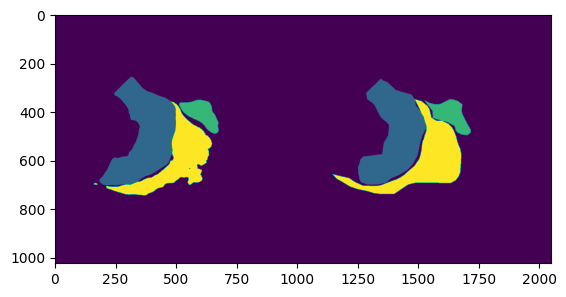

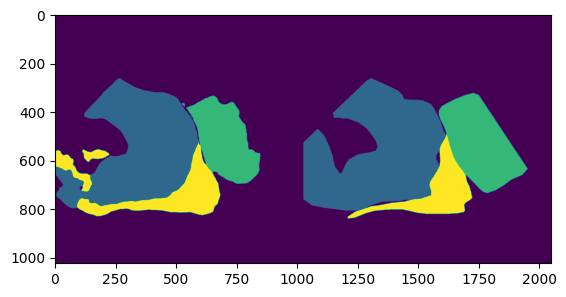

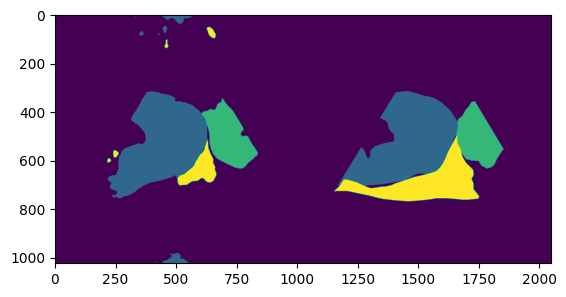

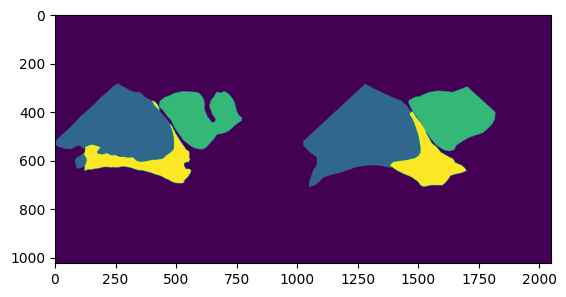

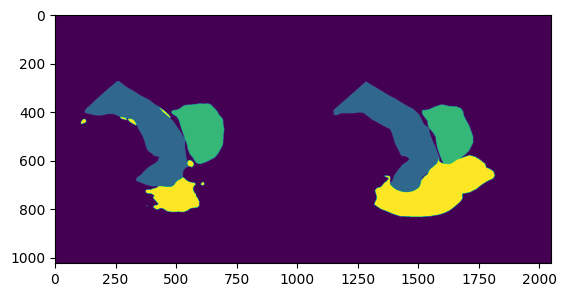

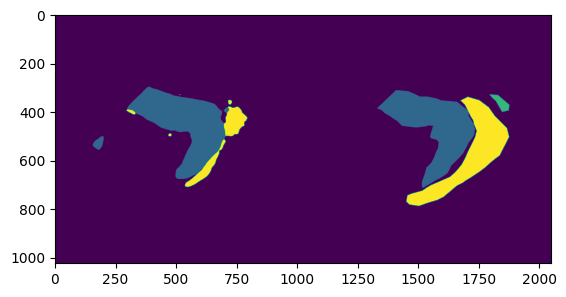

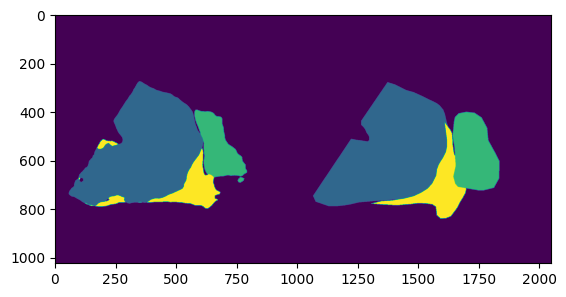

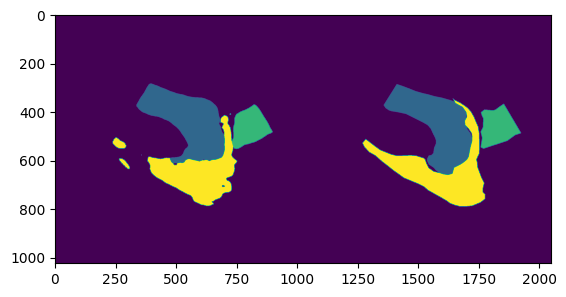

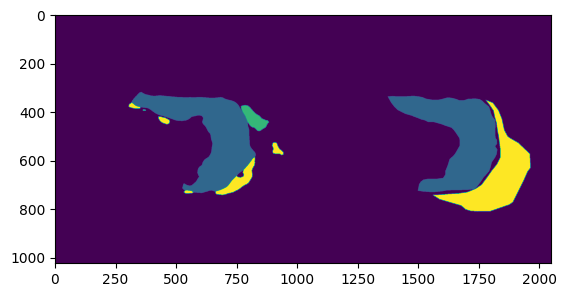

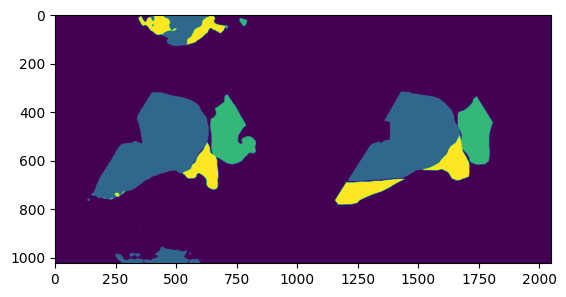

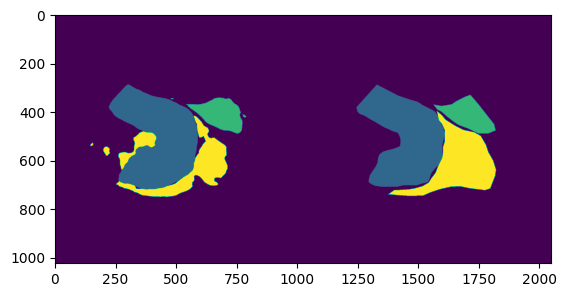

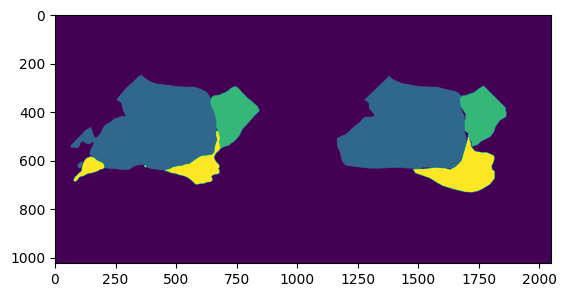

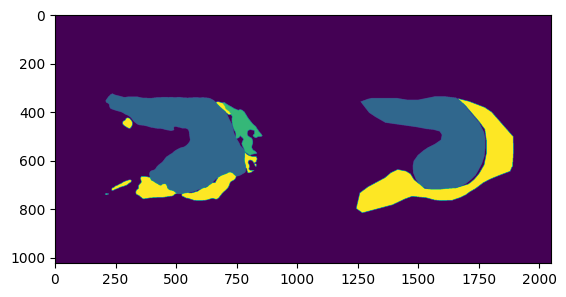

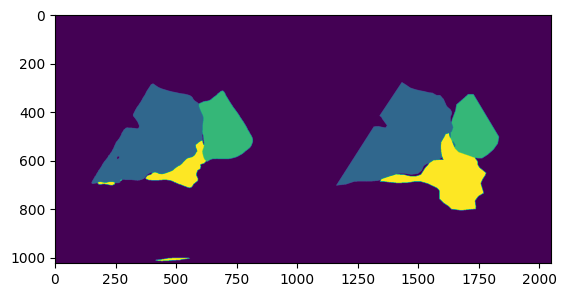

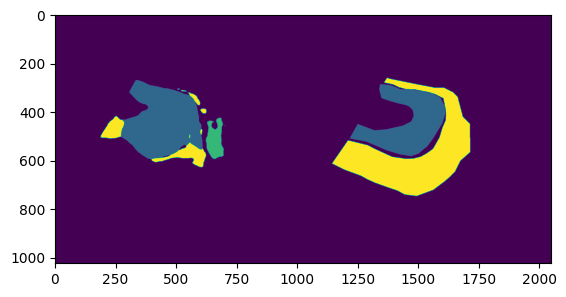

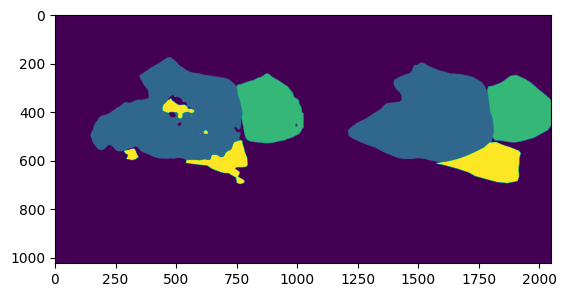

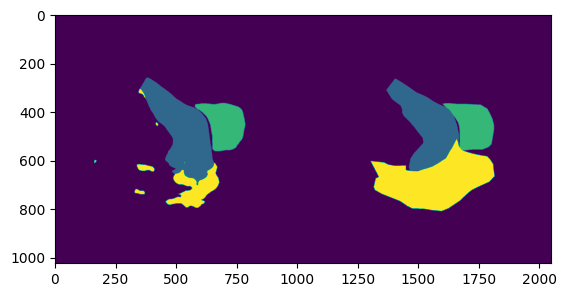

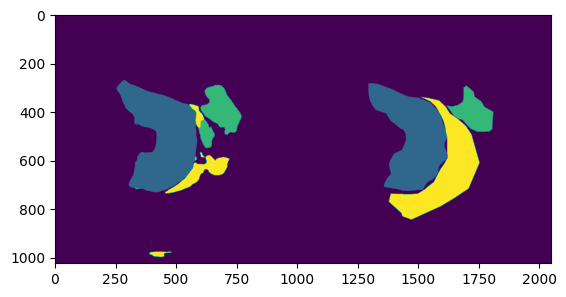

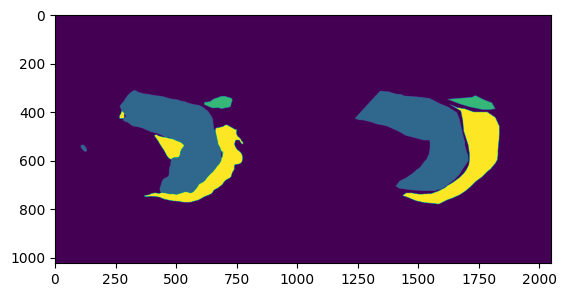

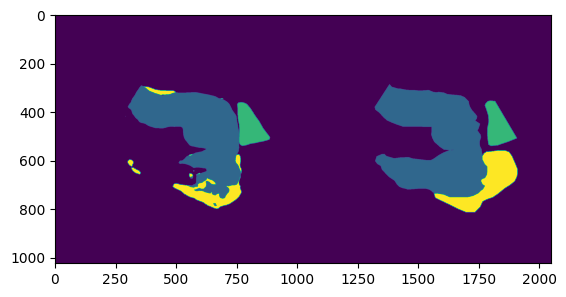

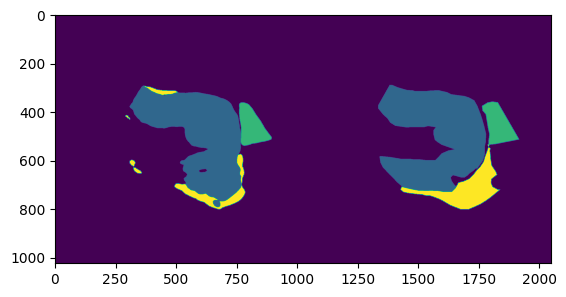

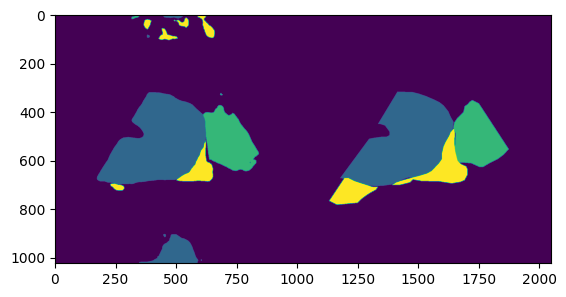

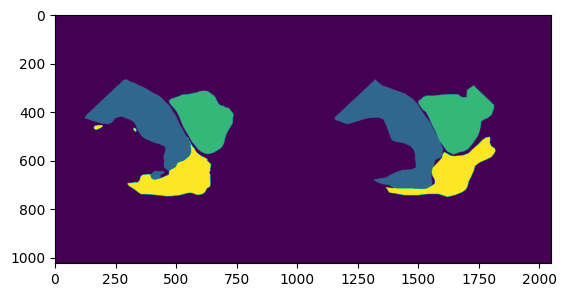

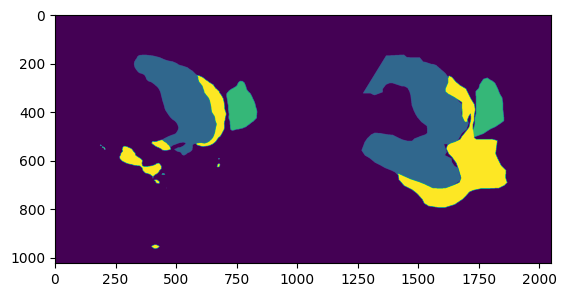

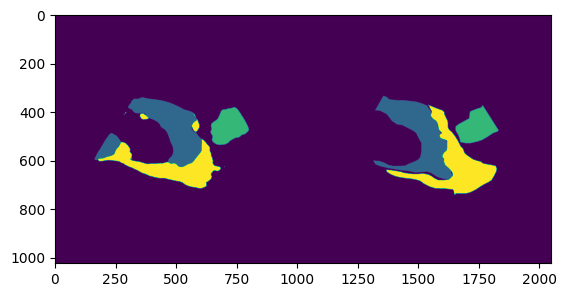

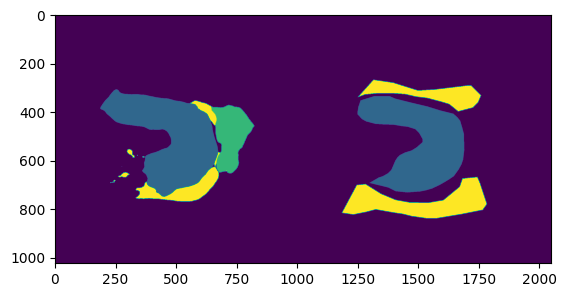

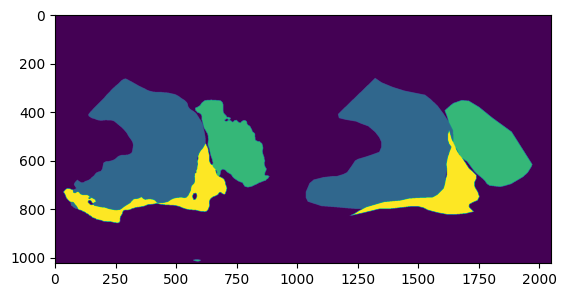

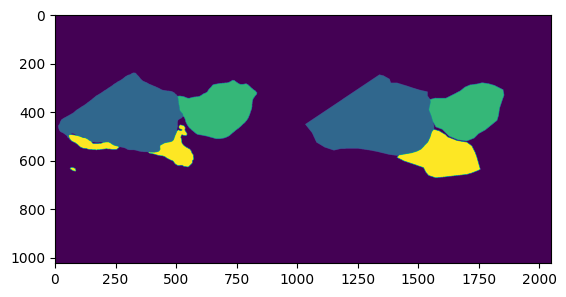

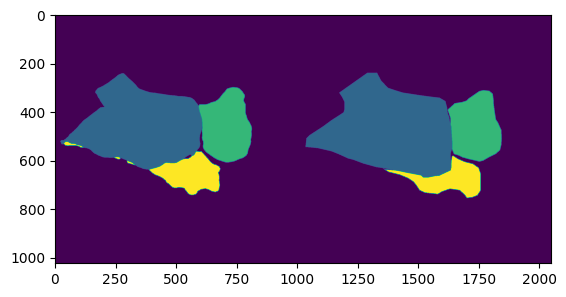

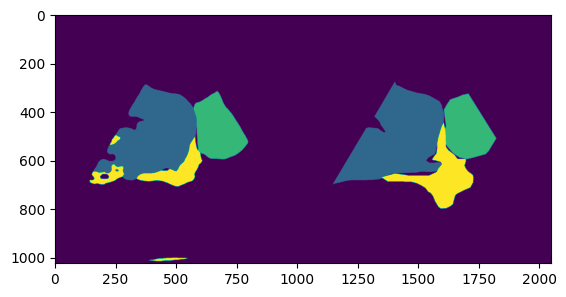

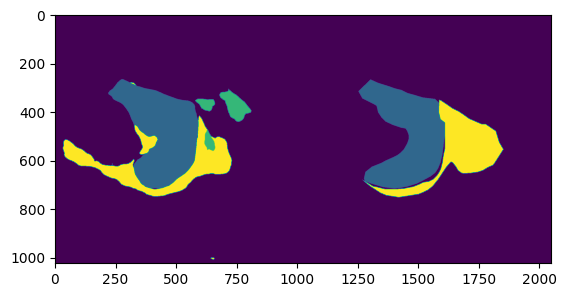

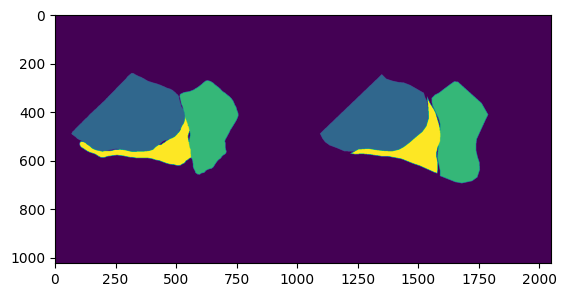

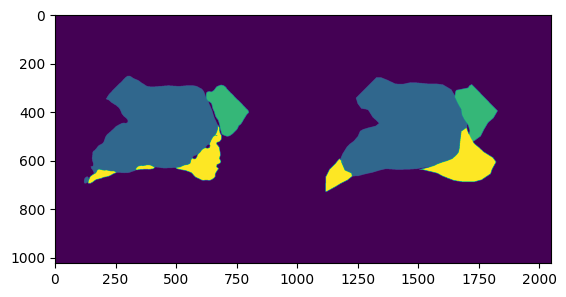

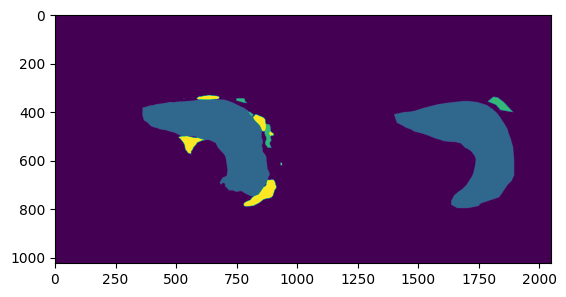

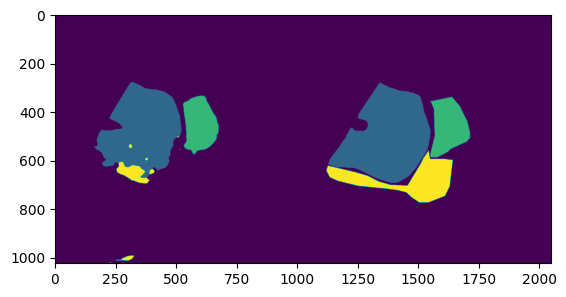

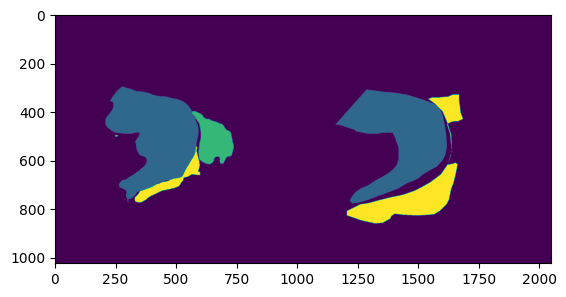

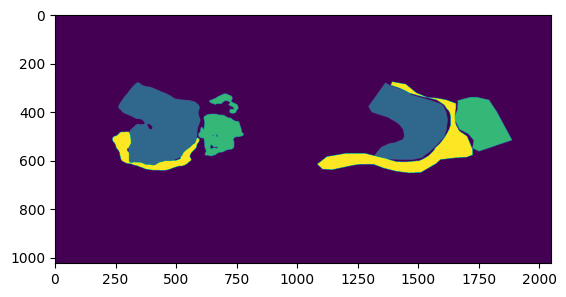

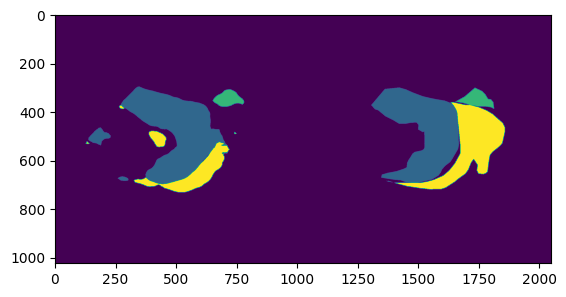

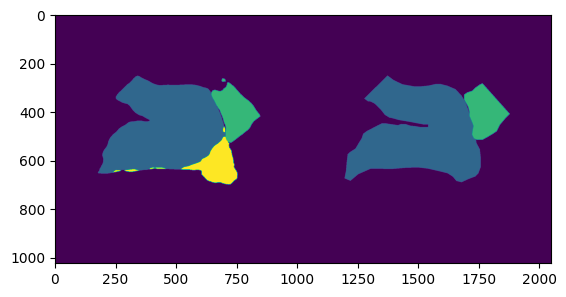

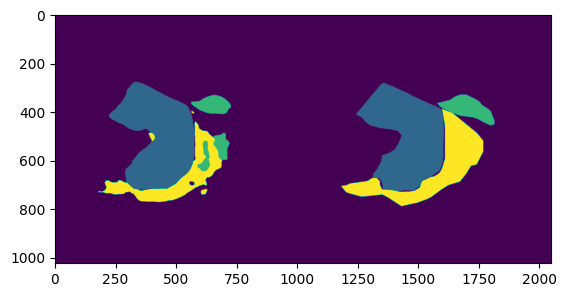

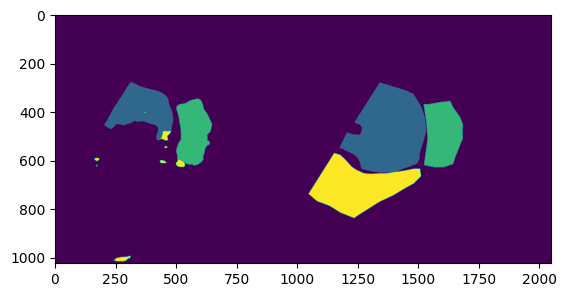

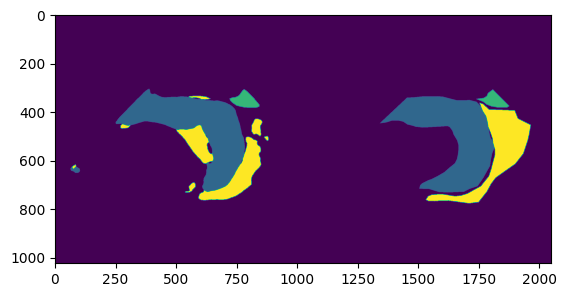

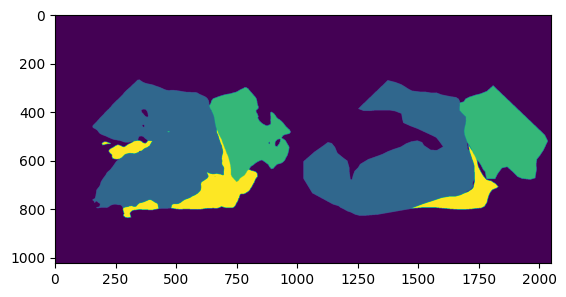

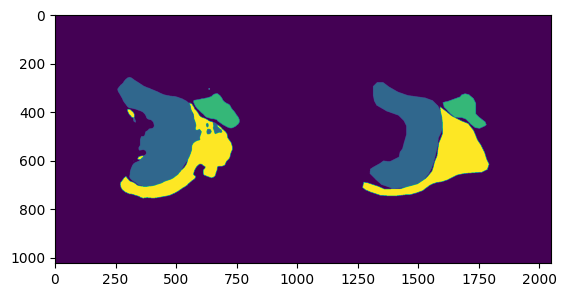

In [6]:
for _ylab,_y in zip(yhat_lab.cpu(),y.cpu()):
    _y[_y==255]=0
    plt.imshow(torch.cat([_ylab,_y],axis=1))
    plt.show()

In [2]:
checkpoint = torch.load(f'/data/LAIPAS_Images/model_checkpoints/{model_name}.pth')
fin_epoch = checkpoint['fin_epoch']
min_loss = checkpoint['min_loss']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
ctl_DATA = LAIPAS_Dataset('/data/LAIPAS_Images/', 'ctl', val_preprocess, msk_preprocess,
                          rot = False, resize=False,crop_size = 1024,ignore=False)
ctl_loader = DataLoader(ctl_DATA, batch_size=4, shuffle=False, drop_last=True, num_workers=4)


In [8]:
model.eval()
with torch.no_grad():
    class_intersect = np.zeros((num_classes,),dtype='float')
    class_union= np.zeros((num_classes,),dtype='float')

    for idx,(X,y) in enumerate(ctl_loader):

        y = y.cuda().contiguous().flatten()
        if 'DLab' in model_name:
            yhat = model(X.contiguous().cuda())['out']
        else:
            yhat = model(X.contiguous().cuda())

        yhat_lab = torch.argmax(yhat, dim=1).flatten()

        for j in range(num_classes):

            y_bi = y == j
            yhat_bi = yhat_lab == j
            I = ((y_bi * yhat_bi).sum()).item()
            U = (y_bi.sum() + yhat_bi.sum() - I).item()
            assert I <= U
            class_intersect[j] += I
            class_union[j] += U

    IOUs = class_intersect/class_union

In [7]:
pred = []
orig = []
img_ = []
model.eval()
with torch.no_grad():
    class_intersect = np.zeros((num_classes,),dtype='float')
    class_union= np.zeros((num_classes,),dtype='float')
    for idx,(X,y) in enumerate(ctl_loader):
        y = y.cuda().contiguous()
        orig.append(y)
        img_.append(X)
        if 'DLab' not in model_name:
            yhat = model(X.contiguous().cuda())
        else:
            yhat = model(X.contiguous().cuda())['out']
        yhat_lab = torch.argmax(yhat, dim=1)
        for j in range(num_classes):

            y_bi = y == j
            yhat_bi = yhat_lab == j
            I = ((y_bi * yhat_bi).sum()).item()
            U = (y_bi.sum() + yhat_bi.sum() - I).item()
            assert I <= U
            class_intersect[j] += I
            class_union[j] += U
            
        pred.append(yhat_lab)
    yhat_lab = torch.cat(pred)
    y = torch.cat(orig)
    X = torch.cat(img_)
        

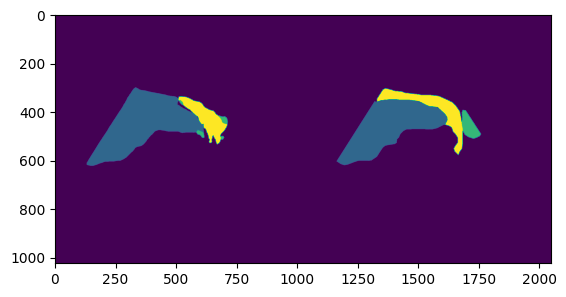

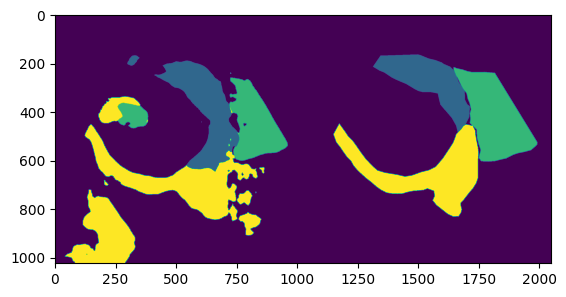

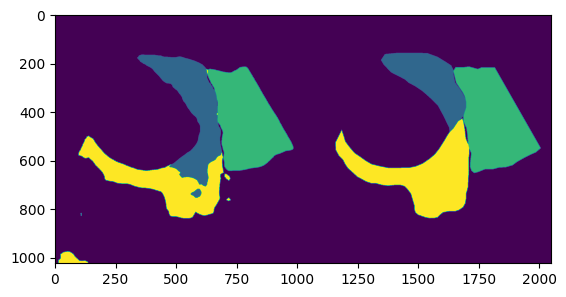

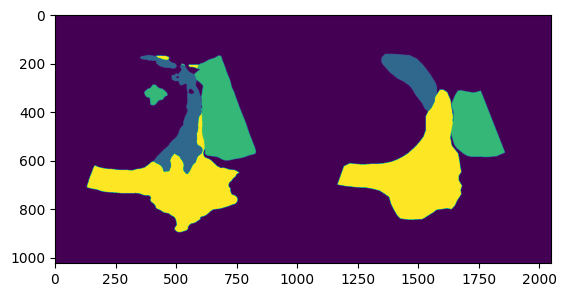

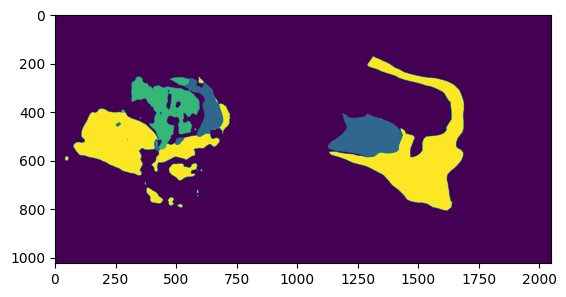

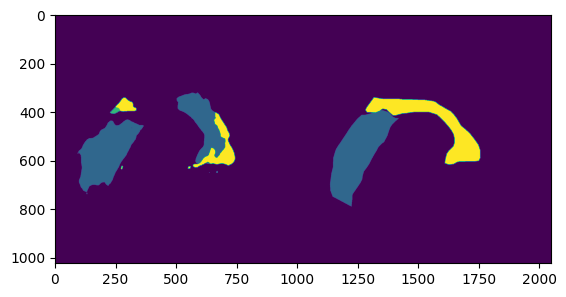

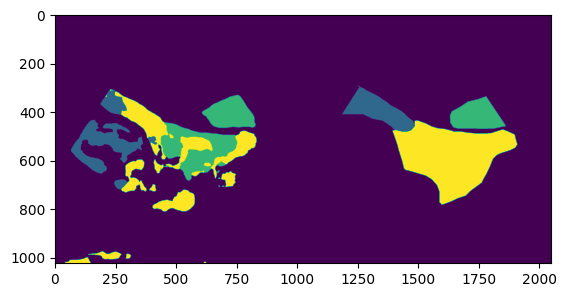

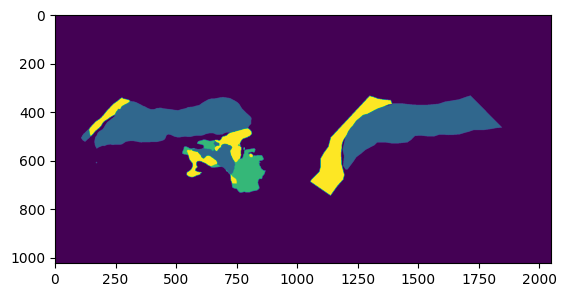

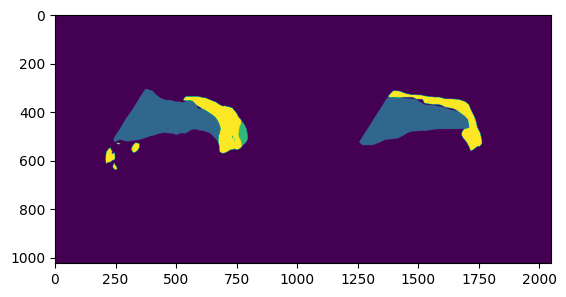

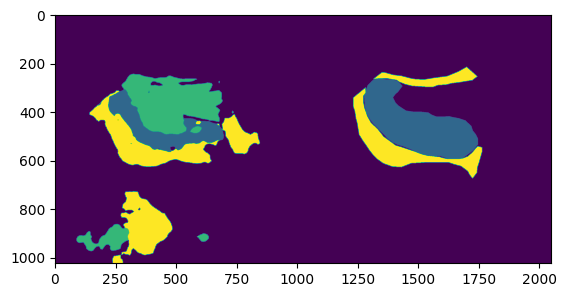

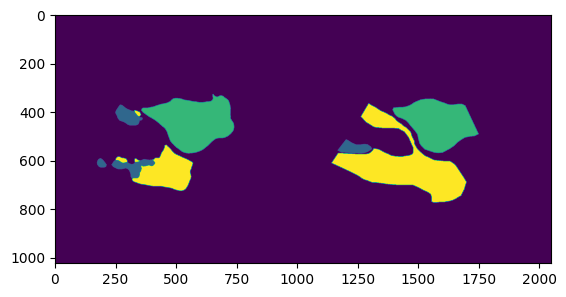

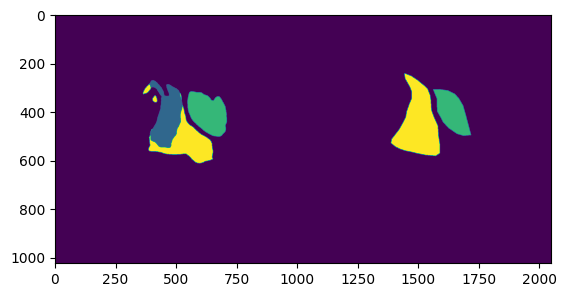

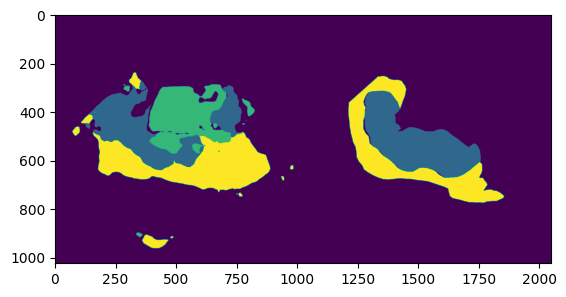

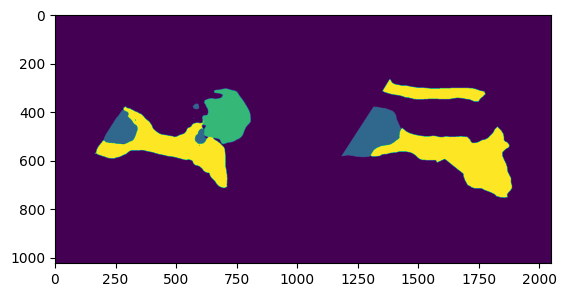

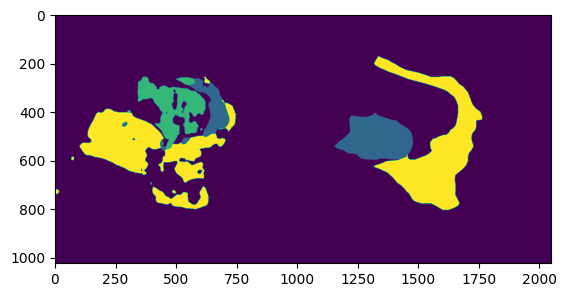

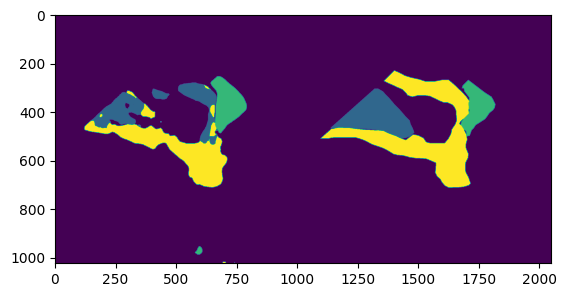

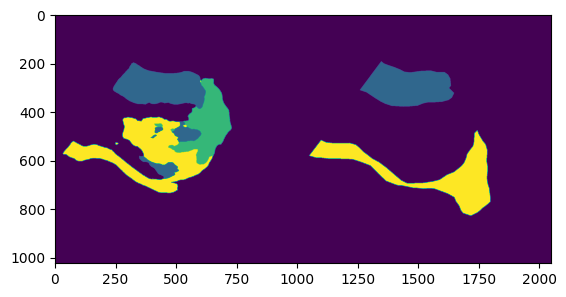

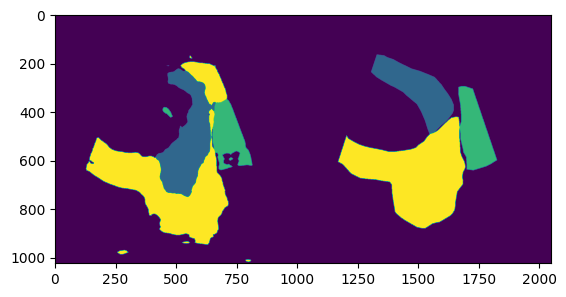

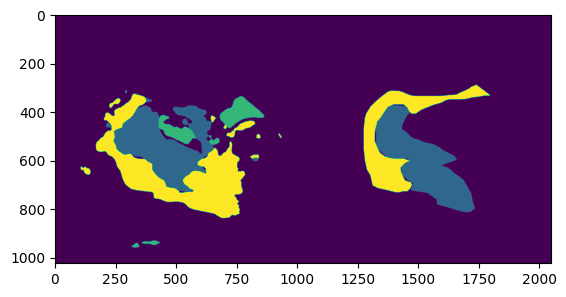

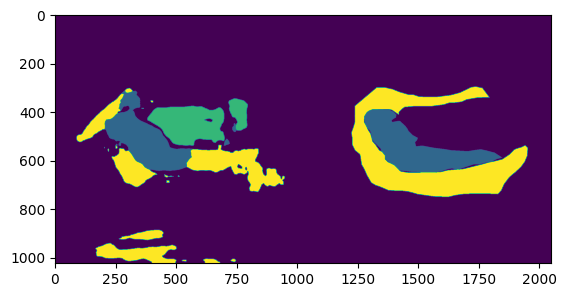

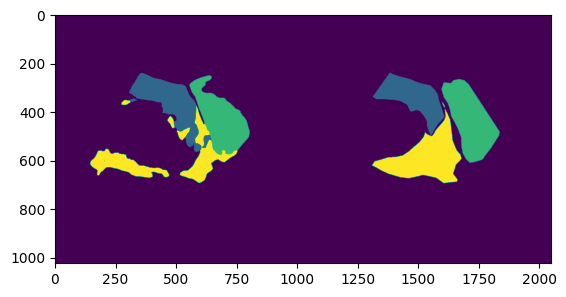

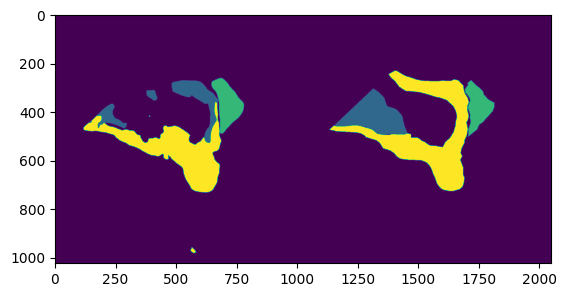

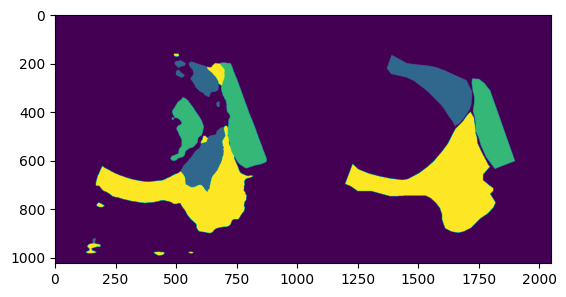

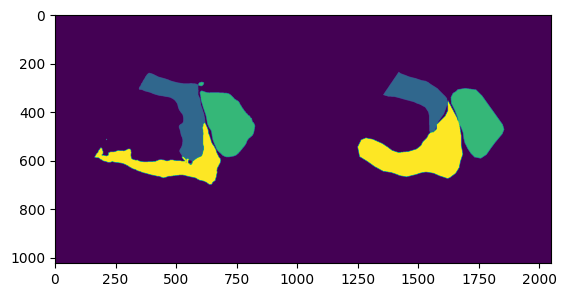

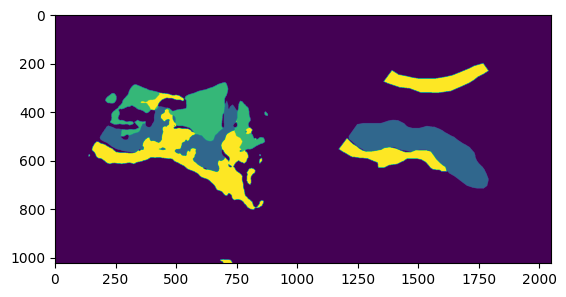

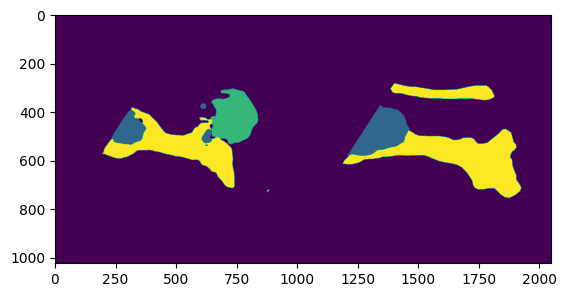

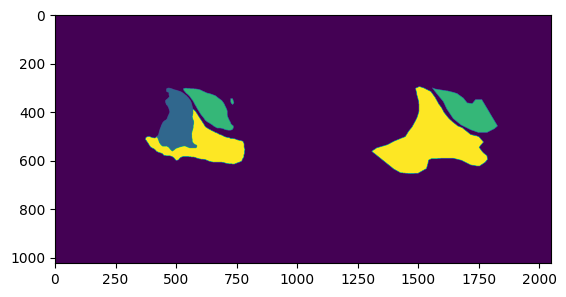

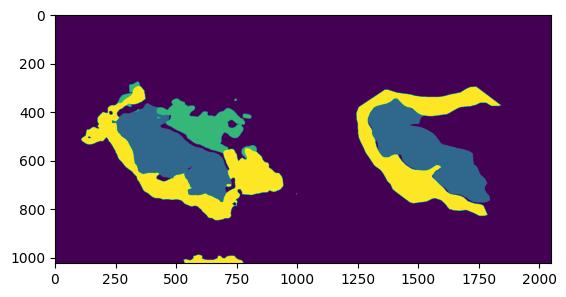

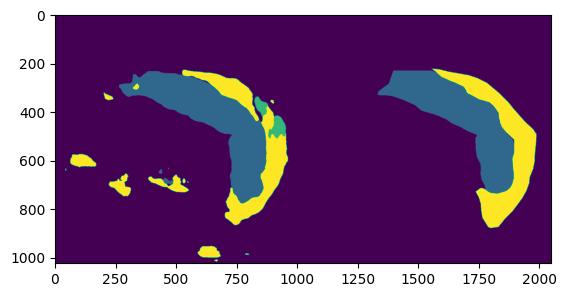

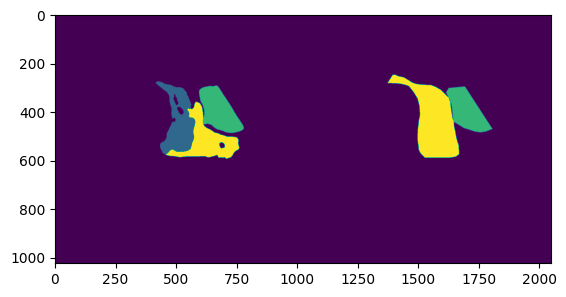

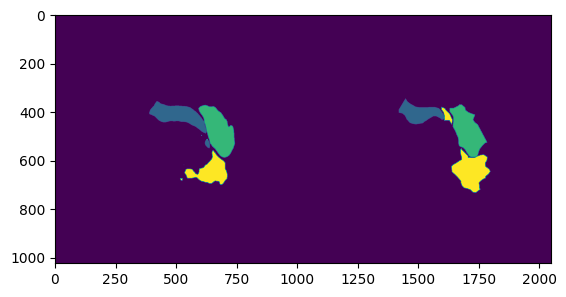

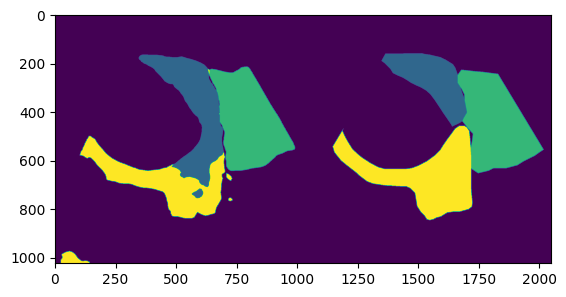

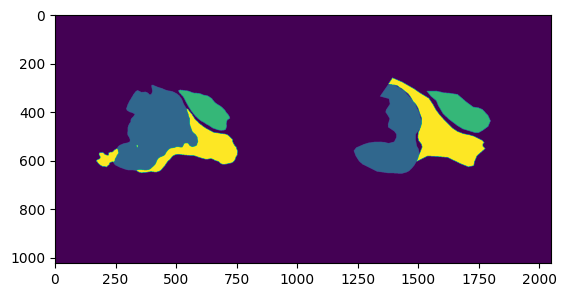

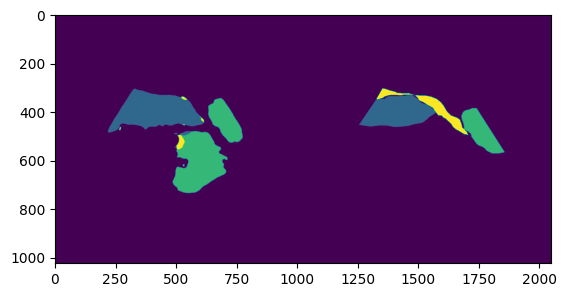

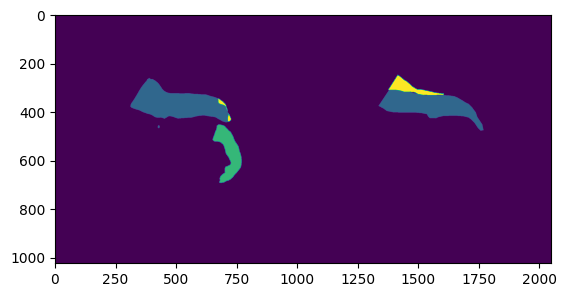

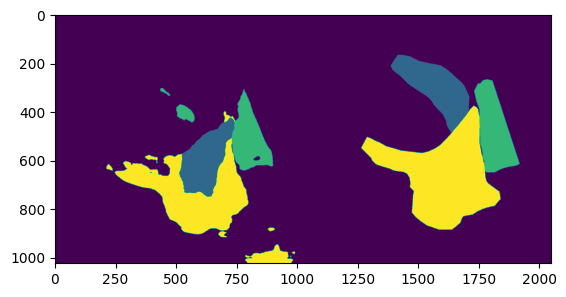

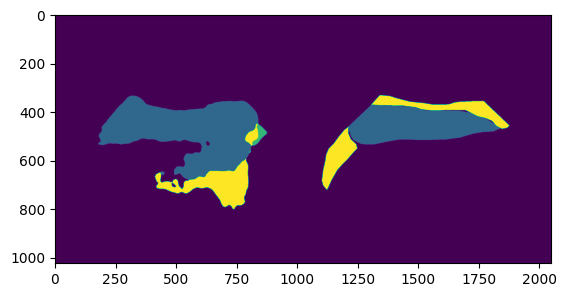

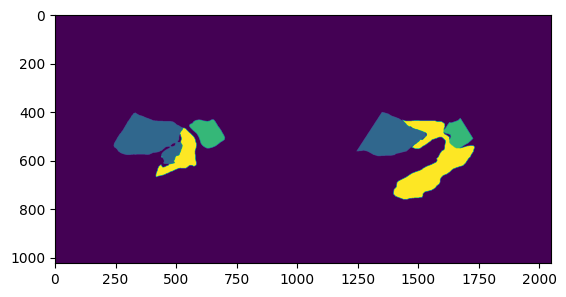

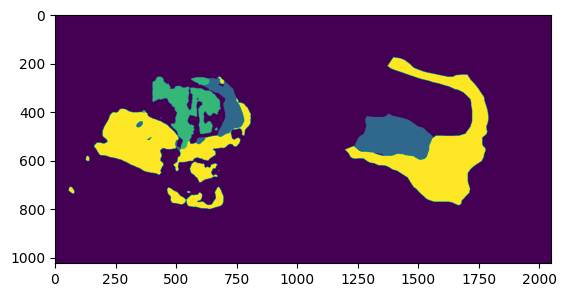

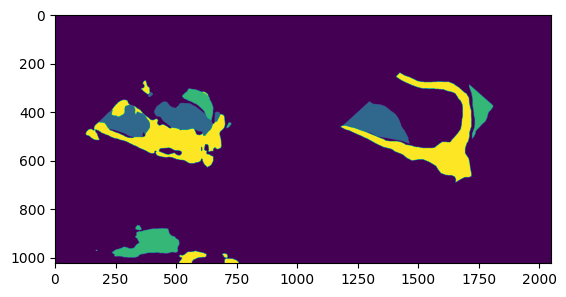

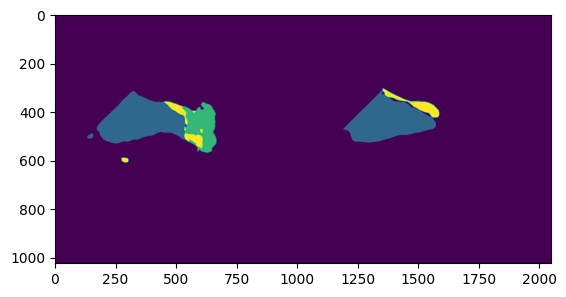

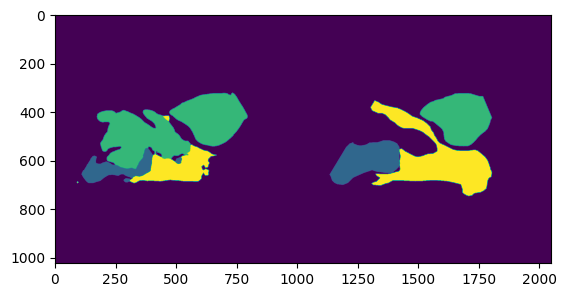

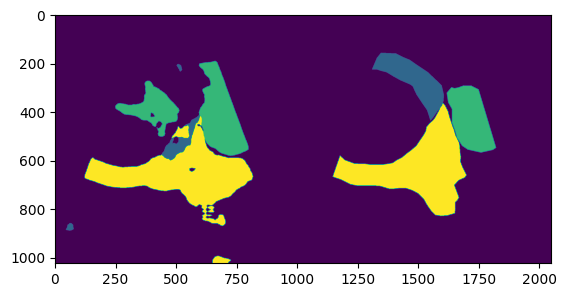

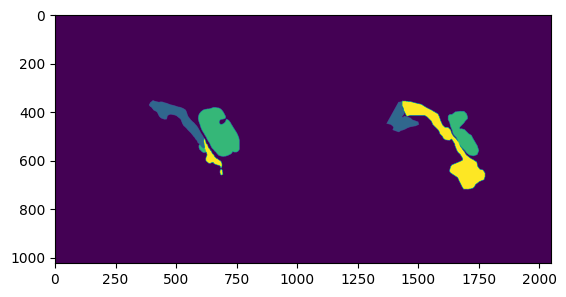

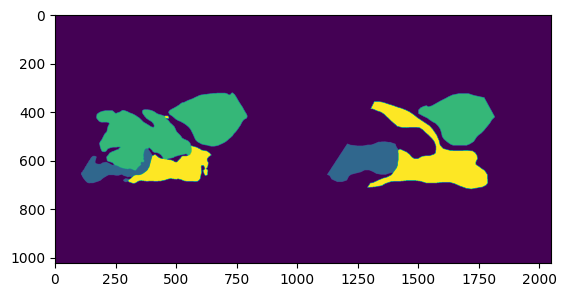

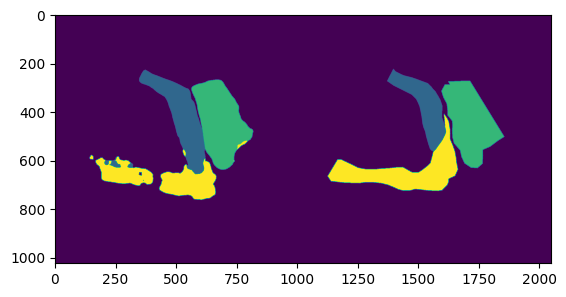

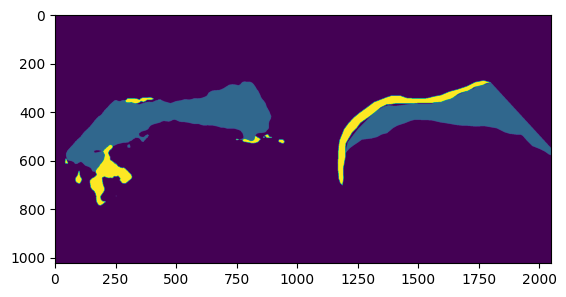

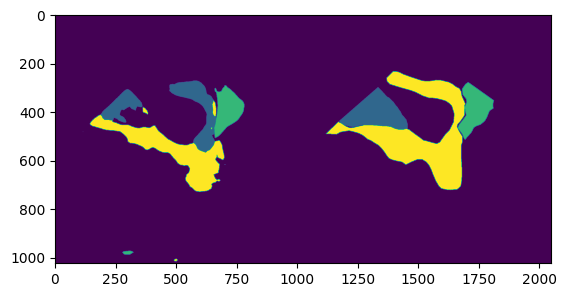

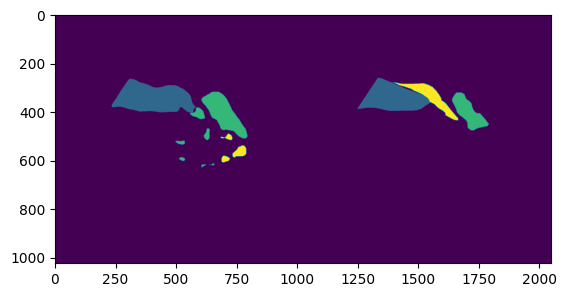

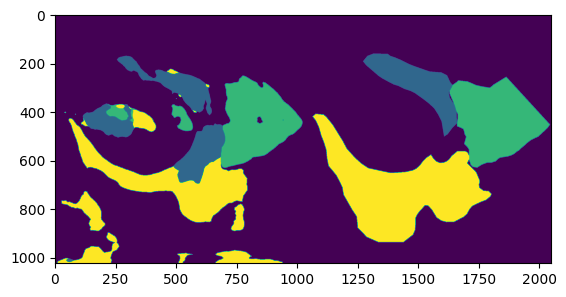

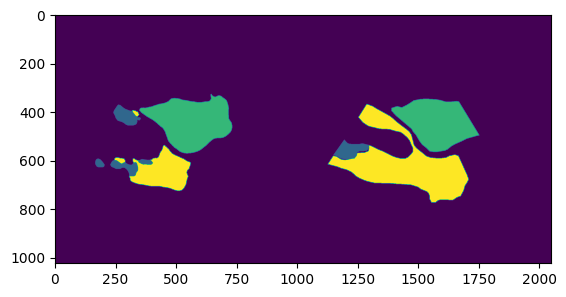

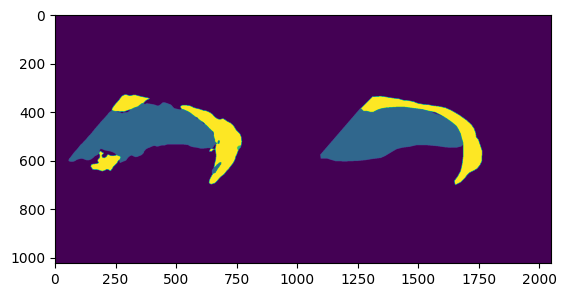

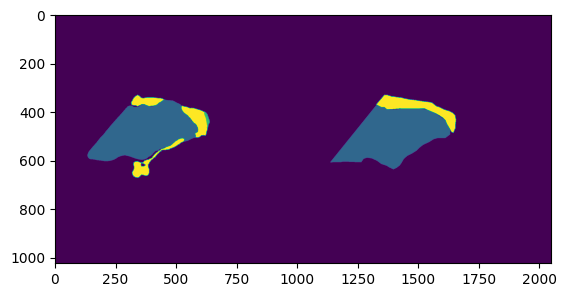

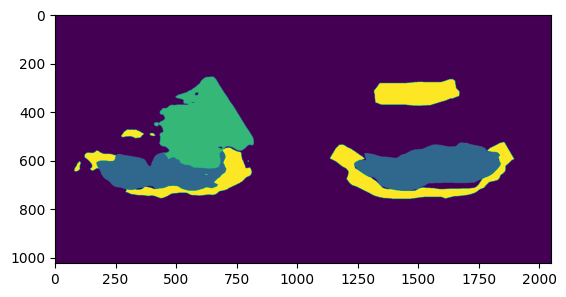

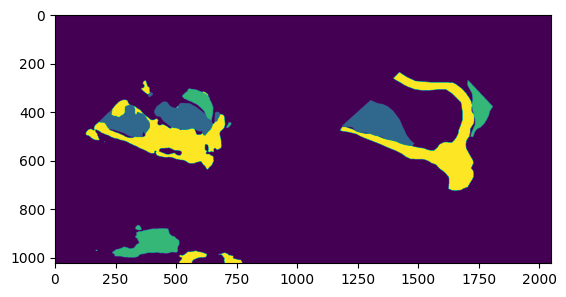

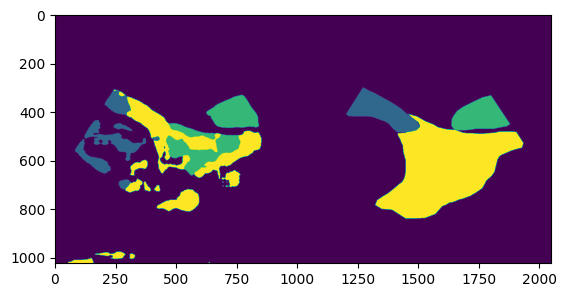

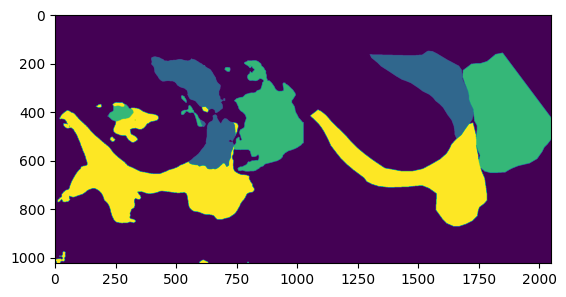

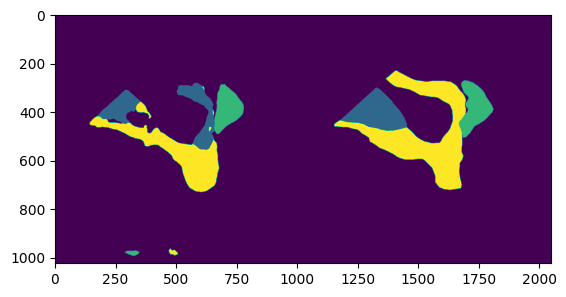

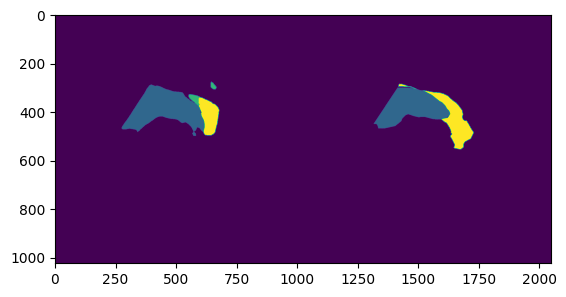

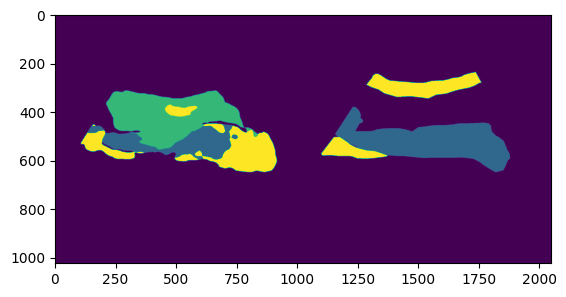

In [8]:
for _ylab,_y in zip(yhat_lab.cpu(),y.cpu()):
    _y[_y==255]=0
    plt.imshow(torch.cat([_ylab,_y],axis=1))
    plt.show()

In [9]:
len(y.cpu())

72